# AudioCLIP Demo

Authored by [Andrey Guzhov](https://github.com/AndreyGuzhov)

This notebook covers common use cases of AudioCLIP and provides the typical workflow.
Below, you will find information on:

0. [Binary Assets](#Downloading-Binary-Assets)
1. [Required imports](#Imports-&-Constants)
2. [Model Instantiation](#Model-Instantiation)
3. [Data Transformation](#Audio-&-Image-Transforms)
4. Data Loading
    * [Audio](#Audio-Loading)
    * [Images](#Image-Loading)
5. [Preparation of the Input](#Input-Preparation)
6. [Acquisition of the Output](#Obtaining-Embeddings)
7. [Normalization of Embeddings](#Normalization-of-Embeddings)
8. [Calculation of Logit Scales](#Obtaining-Logit-Scales)
9. [Computation of Similarities](#Computing-Similarities)
10. Performing Tasks
    1. [Classification](#Classification)
        1. [Audio](#Audio)
        2. [Images](#Images)
    2. [Querying](#Querying)
        1. [Audio by Text](#Audio-by-Text)
        2. [Images by Text](#Images-by-Text)
        3. [Audio by Images](#Audio-by-Images)
        4. [Images by Audio](#Images-by-Audio)

## Downloading Binary Assets

In [ ]:
! wget -P ../assets/ https://github.com/AndreyGuzhov/AudioCLIP/releases/download/v0.1/bpe_simple_vocab_16e6.txt.gz
! wget -P ../assets/ https://github.com/AndreyGuzhov/AudioCLIP/releases/download/v0.1/AudioCLIP-Full-Training.pt

## Imports & Constants

In [1]:
import os
import sys
import glob

import librosa
import librosa.display

import simplejpeg
import numpy as np

import torch
import torchvision as tv

import matplotlib.pyplot as plt

from PIL import Image
from IPython.display import Audio, display

sys.path.append(os.path.abspath(f'{os.getcwd()}/..'))

from model import AudioCLIP
from utils.transforms import ToTensor1D


torch.set_grad_enabled(False)

MODEL_FILENAME = 'AudioCLIP-Full-Training.pt'
# derived from ESResNeXt
SAMPLE_RATE = 44100
# derived from CLIP
IMAGE_SIZE = 224
IMAGE_MEAN = 0.48145466, 0.4578275, 0.40821073
IMAGE_STD = 0.26862954, 0.26130258, 0.27577711

LABELS = ['cat', 'thunderstorm', 'coughing', 'alarm clock', 'car horn']

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/home/rousslan/anaconda3/envs/ss-hab-headless-py39/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Model Instantiation

In [2]:
aclp = AudioCLIP(pretrained=f'../assets/{MODEL_FILENAME}')

In [ ]:
statedict = torch.load(f'../assets/{MODEL_FILENAME}')

In [ ]:
# Isolate the pretrained weight for the audio encoder part only
# statedict.keys()
from typing import OrderedDict

audio_statedict = OrderedDict()
for param_name, param_v in statedict.items():
    if param_name.startswith("audio."):
        stripped_param_name = param_name.replace("audio.", "")

        audio_statedict[stripped_param_name] = param_v

audio_statedict.keys()

In [3]:
# Instantiate the audio model only
# statedict.keys()
from typing import Optional

embed_dim: int = 1024
n_fft: int = 2048
hop_length: Optional[int] = 561
win_length: Optional[int] = 1654
window: Optional[str] = 'blackmanharris'
normalized: bool = True
onesided: bool = True
spec_height: int = -1
spec_width: int = -1
apply_attention: bool = True
multilabel: bool = True

from model.esresnet import ESResNeXtFBSP

# audio_model = ESResNeXtFBSP(
#             n_fft=n_fft,
#             hop_length=hop_length,
#             win_length=win_length,
#             window=window,
#             normalized=normalized,
#             onesided=onesided,
#             spec_height=spec_height,
#             spec_width=spec_width,
#             num_classes=embed_dim,
#             apply_attention=apply_attention,
#             pretrained=False
#         )

In [ ]:
audio_model

In [5]:
from typing import Union, Tuple

from copy import deepcopy

import torch as th
import torch.nn as nn
import torch.nn.functional as F

from model.esresnet import ESResNeXtFBSP

class ESResNeXtFBSP_Binaural(nn.Module):
    def __init__(self, pretrained=None):
        super().__init__()
        monoraul_net = ESResNeXtFBSP(
            n_fft=n_fft,
            hop_length=hop_length,
            win_length=win_length,
            window=window,
            normalized=normalized,
            onesided=onesided,
            spec_height=spec_height,
            spec_width=spec_width,
            num_classes=embed_dim,
            apply_attention=apply_attention,
            pretrained=False
        )
        if pretrained is not None and isinstance(pretrained, str):
            # Loads pre-trained weights from AudioCLIP's audio encoder only
            audioclip_statedict = torch.load(pretrained, map_location="cpu")
            # Extract the audio module's weight only
            audio_statedict = OrderedDict()
            for param_name, param_v in statedict.items():
                if param_name.startswith("audio."):
                    stripped_param_name = param_name.replace("audio.", "")

                    audio_statedict[stripped_param_name] = param_v
            
            monoraul_net.load_state_dict(audio_statedict)
            # NOTE: is this necessary ?
            audioclip_statedict, audio_statedict = None, None

        # TODO: Any more efficient way of re-using the model ?
        self.left_net = monoraul_net
        self.right_net = deepcopy(monoraul_net)

        self.fuse_nn = nn.Sequential(*[
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512)
        ])
    
    def forward(self, x):
        x_left, x_right = x[:, 0, :], x[:, 1, :]

        x_left = self.left_net(x_left)
        x_right = self.right_net(x_right)

        x = th.cat([x_left, x_right], dim=-1)
        x = self.fuse_nn(x)

        return x


In [6]:
audioclip_audio = ESResNeXtFBSP(
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    window=window,
    normalized=normalized,
    onesided=onesided,
    spec_height=spec_height,
    spec_width=spec_width,
    num_classes=embed_dim,
    apply_attention=apply_attention,
    pretrained=False
)
audioclip_encoder_rir = ESResNeXtFBSP_Binaural(audioclip_audio)
audioclip_encoder_rir = audioclip_encoder_rir.to(th.device("cuda"))

In [8]:
import torch as th
audio_dummy_input = th.randn(3, 2, 44100).to(th.device("cuda"))

dummy_output = audioclip_encoder_rir(audio_dummy_input)

In [ ]:
dummy_output.shape

In [ ]:
# Checks the parameter names in the audio model
# audio_model.state_dict().keys()

# Load the pretrained weights
audio_model.load_state_dict(audio_statedict)

In [ ]:
audio_model.to(torch.device("cuda:0"))

In [ ]:
# Investigate the AudioClip's audio module for SS integration
# import torchinfo
# from torchinfo import summary
# summary(aclp.audio)
aclp.audio

# Testing putting the audio model onto GPU
# import torch as th
# device = th.device("cuda")
# aclp.audio.to(device)
# from torchinfo import summary

## Audio & Image Transforms

In [4]:
audio_transforms = ToTensor1D()

image_transforms = tv.transforms.Compose([
    tv.transforms.ToTensor(),
    tv.transforms.Resize(IMAGE_SIZE, interpolation=Image.BICUBIC),
    tv.transforms.CenterCrop(IMAGE_SIZE),
    tv.transforms.Normalize(IMAGE_MEAN, IMAGE_STD)
])

/tmp/ipykernel_1326690/1934972055.py:5: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  tv.transforms.Resize(IMAGE_SIZE, interpolation=Image.BICUBIC),
/home/rousslan/anaconda3/envs/ss-hab-headless-py39/lib/python3.9/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


## Audio Loading
Audio samples are drawn from the [ESC-50](https://github.com/karolpiczak/ESC-50) dataset.

In [21]:
paths_to_audio = glob.glob('audio/*.wav')

audio = list()
for path_to_audio in paths_to_audio:
    track, _ = librosa.load(path_to_audio, sr=SAMPLE_RATE, dtype=np.float32)

    # compute spectrograms using trained audio-head (fbsp-layer of ESResNeXt)
    # thus, the actual time-frequency representation will be visualized
    spec = aclp.audio.spectrogram(torch.from_numpy(track.reshape(1, 1, -1)))
    spec = np.ascontiguousarray(spec.numpy()).view(np.complex64)
    pow_spec = 10 * np.log10(np.abs(spec) ** 2 + 1e-18).squeeze()

    audio.append((track, pow_spec))

In [22]:
# Investigating the expected input specs for the audio component of the model
audio[0][0].shape, audio[0][1].shape # ((220500,), (1025, 392)) for SR=44.1KHz

((220500,), (1025, 392))

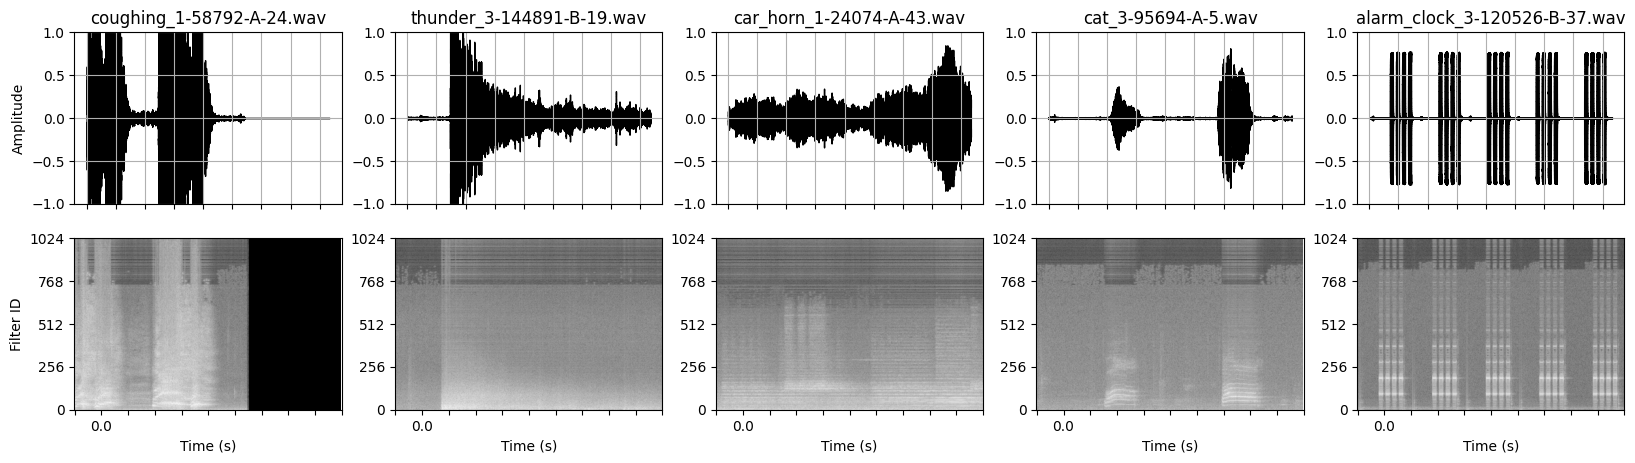

coughing_1-58792-A-24.wav


thunder_3-144891-B-19.wav


car_horn_1-24074-A-43.wav


cat_3-95694-A-5.wav


alarm_clock_3-120526-B-37.wav


In [23]:
from librosa.display import waveshow
fig, axes = plt.subplots(2, len(audio), figsize=(20, 5), dpi=100)

for idx in range(len(audio)):
    track, pow_spec = audio[idx]

    # draw the waveform
    # librosa.display.waveplot(track, sr=SAMPLE_RATE, ax=axes[0, idx], color='k')
    waveshow(track, sr=SAMPLE_RATE, ax=axes[0, idx], color='k')
    # show the corresponding power spectrogram
    axes[1, idx].imshow(pow_spec, origin='lower', aspect='auto', cmap='gray', vmin=-180.0, vmax=20.0)

    # modify legend
    axes[0, idx].set_title(os.path.basename(paths_to_audio[idx]))
    axes[0, idx].set_xlabel('')
    axes[0, idx].set_xticklabels([])
    axes[0, idx].grid(True)
    axes[0, idx].set_ylim(bottom=-1, top=1)

    axes[1, idx].set_xlabel('Time (s)')
    axes[1, idx].set_xticks(np.linspace(0, pow_spec.shape[1], len(axes[0, idx].get_xticks())))
    axes[1, idx].set_xticklabels([f'{tick:.1f}' if tick == int(tick) else '' for tick in axes[0, idx].get_xticks()])
    axes[1, idx].set_yticks(np.linspace(0, pow_spec.shape[0] - 1, 5))

axes[0, 0].set_ylabel('Amplitude')
axes[1, 0].set_ylabel('Filter ID')

plt.show()
plt.close(fig)

for idx, path in enumerate(paths_to_audio):
    print(os.path.basename(path))
    display(Audio(audio[idx][0], rate=SAMPLE_RATE, embed=True))

## Image Loading

In [24]:
paths_to_images = glob.glob('images/*.jpg')

images = list()
for path_to_image in paths_to_images:
    with open(path_to_image, 'rb') as jpg:
        image = simplejpeg.decode_jpeg(jpg.read())
        images.append(image)

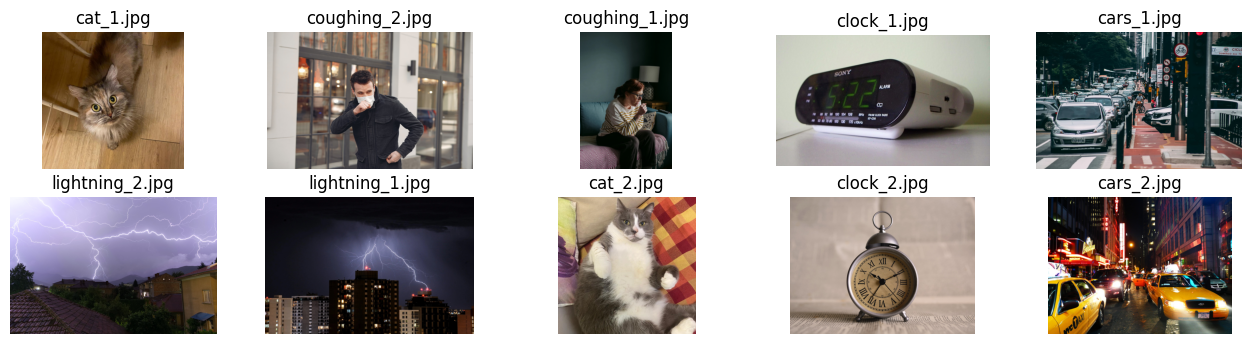

In [25]:
fig, axes = plt.subplots(2, len(images) // 2, figsize=(16, 4), dpi=100)

for idx, jdx in np.ndindex(axes.shape):
    # re-arrange order to show the images column-wise
    image_idx = np.ravel_multi_index(((jdx,), (idx,)), axes.shape[::-1]).item()
    axes[idx, jdx].imshow(images[image_idx])

    # modify legend
    axes[idx, jdx].axis('off')
    axes[idx, jdx].set_title(os.path.basename(paths_to_images[image_idx]))

plt.show()
plt.close(fig)

## Input Preparation

In [26]:
# AudioCLIP handles raw audio on input, so the input shape is [batch x channels x duration]
audio = torch.stack([audio_transforms(track.reshape(1, -1)) for track, _ in audio])
# standard channel-first shape [batch x channels x height x width]
images = torch.stack([image_transforms(image) for image in images])
# textual input is processed internally, so no need to transform it beforehand
text = [[label] for label in LABELS]

In [27]:
# Checking shape of raw audio input
audio.shape # torch.Size([5, 1, 220500])

torch.Size([5, 1, 220500])

## Obtaining Embeddings
For the sake of clarity, all three modalities are processed separately.

In [ ]:
# AudioCLIP's output: Tuple[Tuple[Features, Logits], Loss]
# Features = Tuple[AudioFeatures, ImageFeatures, TextFeatures]
# Logits = Tuple[AudioImageLogits, AudioTextLogits, ImageTextLogits]

((audio_features, _, _), _), _ = aclp(audio=audio)
((_, image_features, _), _), _ = aclp(image=images)
((_, _, text_features), _), _ = aclp(text=text)

In [ ]:
# Cheking the audio features
audio_features.shape

## Normalization of Embeddings
The AudioCLIP's output is normalized using L<sub>2</sub>-norm

In [ ]:
audio_features = audio_features / torch.linalg.norm(audio_features, dim=-1, keepdim=True)
image_features = image_features / torch.linalg.norm(image_features, dim=-1, keepdim=True)
text_features = text_features / torch.linalg.norm(text_features, dim=-1, keepdim=True)

## Obtaining Logit Scales
Outputs of the text-, image- and audio-heads are made consistent using dedicated scaling terms for each pair of modalities.
The scaling factors are clamped between 1.0 and 100.0.

In [ ]:
scale_audio_image = torch.clamp(aclp.logit_scale_ai.exp(), min=1.0, max=100.0)
scale_audio_text = torch.clamp(aclp.logit_scale_at.exp(), min=1.0, max=100.0)
scale_image_text = torch.clamp(aclp.logit_scale.exp(), min=1.0, max=100.0)

## Computing Similarities
Similarities between different representations of a same concept are computed using [scaled](#Obtaining-Logit-Scales) dot product (cosine similarity).

In [ ]:
logits_audio_image = scale_audio_image * audio_features @ image_features.T
logits_audio_text = scale_audio_text * audio_features @ text_features.T
logits_image_text = scale_image_text * image_features @ text_features.T

## Classification
This task is a specific case of a more general one, which is [querying](#Querying).
However, this setup is mentioned as a standalone because it demonstrates clearly how to perform usual classification (including [zero-shot inference](https://github.com/openai/CLIP#zero-shot-prediction)) using AudioCLIP.

### Audio

In [ ]:
print('\t\tFilename, Audio\t\t\tTextual Label (Confidence)', end='\n\n')

# calculate model confidence
confidence = logits_audio_text.softmax(dim=1)
for audio_idx in range(len(paths_to_audio)):
    # acquire Top-3 most similar results
    conf_values, ids = confidence[audio_idx].topk(3)

    # format output strings
    query = f'{os.path.basename(paths_to_audio[audio_idx]):>30s} ->\t\t'
    results = ', '.join([f'{LABELS[i]:>15s} ({v:06.2%})' for v, i in zip(conf_values, ids)])

    print(query + results)

### Images

In [ ]:
print('\tFilename, Image\t\t\tTextual Label (Confidence)', end='\n\n')

# calculate model confidence
confidence = logits_image_text.softmax(dim=1)
for image_idx in range(len(paths_to_images)):
    # acquire Top-3 most similar results
    conf_values, ids = confidence[image_idx].topk(3)

    # format output strings
    query = f'{os.path.basename(paths_to_images[image_idx]):>20s} ->\t\t'
    results = ', '.join([f'{LABELS[i]:>20s} ({v:06.2%})' for v, i in zip(conf_values, ids)])

    print(query + results)

## Querying

### Audio by Text

In [ ]:
print('\t\tTextual Label\t\tFilename, Audio (Confidence)', end='\n\n')

# calculate model confidence
confidence = logits_audio_text.softmax(dim=0)
for label_idx in range(len(LABELS)):
    # acquire Top-2 most similar results
    conf_values, ids = confidence[:, label_idx].topk(2)

    # format output strings
    query = f'{LABELS[label_idx]:>25s} ->\t\t'
    results = ', '.join([f'{os.path.basename(paths_to_audio[i]):>30s} ({v:06.2%})' for v, i in zip(conf_values, ids)])

    print(query + results)

### Images by Text

In [ ]:
print('\tTextual Label\t\t\tFilename, Image (Confidence)', end='\n\n')

# calculate model confidence
confidence = logits_image_text.softmax(dim=0)
for label_idx in range(len(LABELS)):
    # acquire Top-3 most similar results
    conf_values, ids = confidence[:, label_idx].topk(3)

    # format output strings
    query = f'{LABELS[label_idx]:>20s} ->\t\t'
    results = ', '.join([f'{os.path.basename(paths_to_images[i]):>20s} ({v:>06.2%})' for v, i in zip(conf_values, ids)])

    print(query + results)

### Audio by Images

In [ ]:
print('\tTextual Label\t\t\tFilename, Image (Confidence)', end='\n\n')

# calculate model confidence
confidence = logits_audio_image.softmax(dim=0)
for image_idx in range(len(paths_to_images)):
    # acquire Top-2 most similar results
    conf_values, ids = confidence[:, image_idx].topk(2)

    # format output strings
    query = f'{os.path.basename(paths_to_images[image_idx]):>25s} ->\t\t'
    results = ', '.join([f'{os.path.basename(paths_to_audio[i]):>30s} ({v:06.2%})' for v, i in zip(conf_values, ids)])

    print(query + results)

### Images by Audio

In [ ]:
print('\tTextual Label\t\t\tFilename, Image (Confidence)', end='\n\n')

# calculate model confidence
confidence = logits_audio_image.softmax(dim=1)
for audio_idx in range(len(paths_to_audio)):
    # acquire Top-3 most similar results
    conf_values, ids = confidence[audio_idx].topk(3)

    # format output strings
    query = f'{os.path.basename(paths_to_audio[audio_idx]):>30s} ->\t\t'
    results = ', '.join([f'{os.path.basename(paths_to_images[i]):>15s} ({v:06.2%})' for v, i in zip(conf_values, ids)])

    print(query + results)